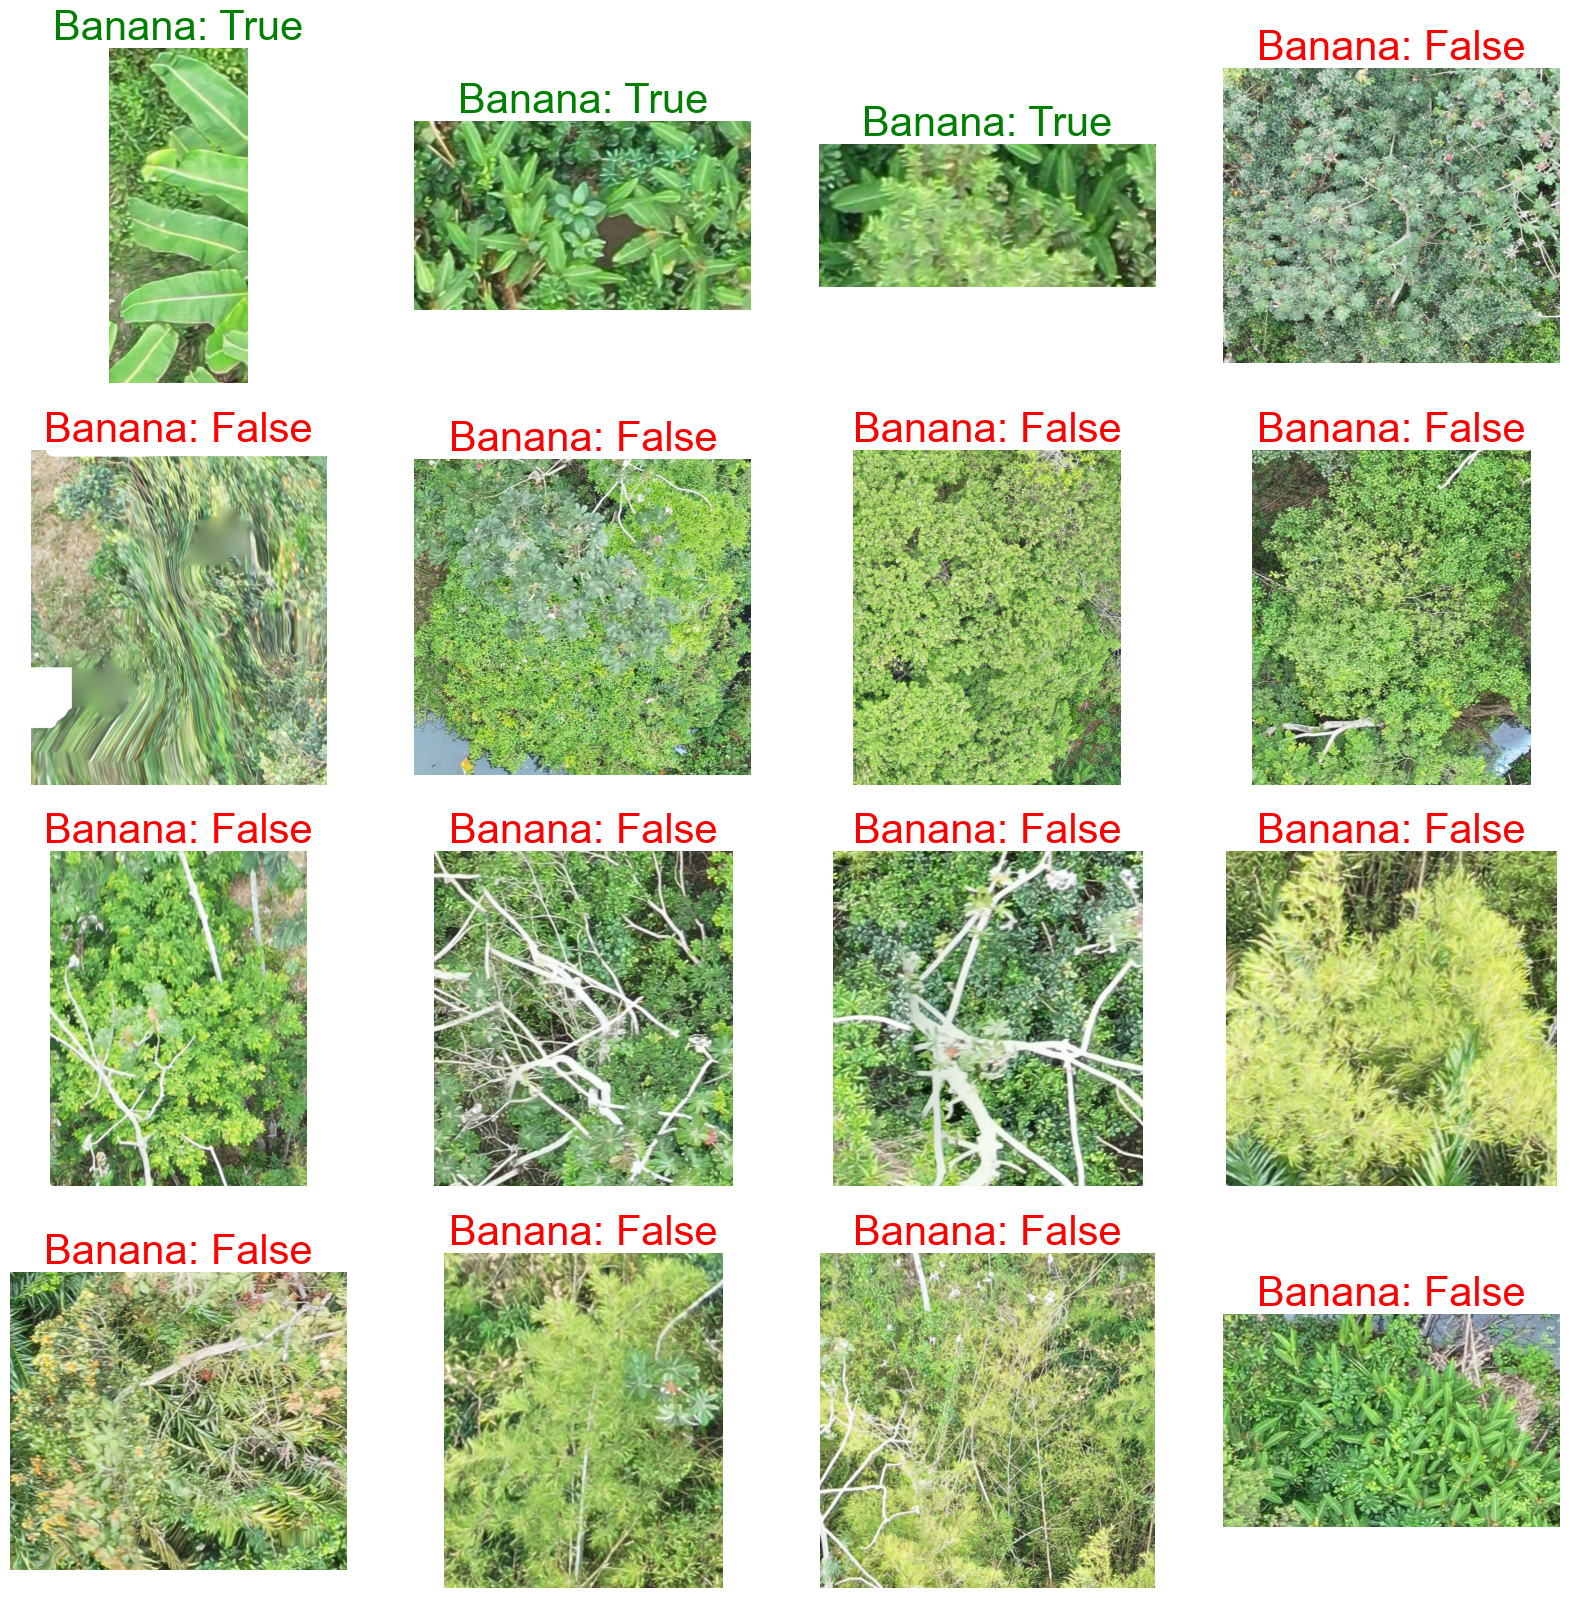

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
df = pd.read_csv('final_dataset.csv')

# Filter the dataframe for the specific image
img_data = df[df['img_path'] == 'Manuel Macias RGB_3_3800_0_7800_4000.png']

# Load the image
img = cv2.imread('../tiles/Manuel Macias RGB/' + img_data['img_path'].values[0])

# List to store the cutouts and labels
cutouts = []
labels = []

# Extract each bounding box and cut out the corresponding region from the original image
for i, row in enumerate(img_data.iterrows()):

    xmin, ymin, xmax, ymax = int(row[1]['xmin']), int(row[1]['ymin']), int(row[1]['xmax']), int(row[1]['ymax'])

    # Cut out the region of interest from the original image
    roi = img[ymin:ymax, xmin:xmax]

    # Store the cutout and label in the list
    cutouts.append(roi)
    labels.append(row[1]['is_banana'])

# Display the cutouts in a grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axs.flatten()):
    if i < len(cutouts):
        color = 'green' if labels[i] else 'red'  # Change the color based on the label
        ax.imshow(cv2.cvtColor(cutouts[i], cv2.COLOR_BGR2RGB))
        ax.set_title('Banana: ' + str(labels[i]), fontsize=30, color=color)  # Set the color here
        ax.axis('off')

plt.show()

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('final_dataset.csv')

# List to store the resized and normalized cutouts and labels
resized_cutouts = []
encoded_labels = []

# Get all unique image paths
unique_img_paths = df['img_path'].unique()

# Loop over all unique image paths
for img_path in unique_img_paths:

    # Filter the dataframe for the specific image
    img_data = df[df['img_path'] == img_path]

    # Initialize the image variable
    img = None

    # Traverse through all the subfolders and files in the tiles directory
    for root, dirs, files in os.walk('../tiles/'):
        if img_path in files:
            # Load the image
            img = cv2.imread(os.path.join(root, img_path))
            break

    # If the image was not found, skip this iteration
    if img is None:
        continue

    # Extract each bounding box, resize, normalize and store it
    # what is img_data.iterrows()? 
    for i, row in img_data.iterrows():

        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

        # Cut out the region of interest from the original image
        roi = img[ymin:ymax, xmin:xmax]

        # Resize the cutout to 64x64 (or any size your model requires)
        # what is cv2.resize doing? 
        roi = cv2.resize(roi, (64, 64))

        # Normalize the cutout
        roi = roi / 255.0

        # Store the resized and normalized cutout
        resized_cutouts.append(roi)

        # Store the label
        encoded_labels.append(row['is_banana'])
        
        # # take the name = Musacea
        # if row['name'] == 'Musacea':
        #     encoded_labels.append(1)
        # else:
        #     encoded_labels.append(0)
            

# Convert the cutouts and labels to numpy arrays
resized_cutouts = np.array(resized_cutouts)
encoded_labels = np.array(encoded_labels)
# using binary_crossentropy and sigmoid so no need to use labelencoder
# binary_crossentropy gives 88% accuracy for is_banana and 90% accuracy for row['name'] == 'Musacea'
print(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(resized_cutouts, encoded_labels, test_size=0.2, random_state=42)

[ True  True  True ... False False False]


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3730, 64, 64, 3)
(933, 64, 64, 3)
(3730,)
(933,)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Dropout layer after first MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Dropout layer after second MaxPooling
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer after Dense layer
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.save('banana_classification_model.h5')

In [5]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6476 - loss: 0.7470 - val_accuracy: 0.6838 - val_loss: 0.6124
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6901 - loss: 0.5789 - val_accuracy: 0.7460 - val_loss: 0.5878
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7205 - loss: 0.5346 - val_accuracy: 0.7138 - val_loss: 0.5187
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7876 - loss: 0.4671 - val_accuracy: 0.7856 - val_loss: 0.5042
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7737 - loss: 0.4942 - val_accuracy: 0.8221 - val_loss: 0.3937
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8062 - loss: 0.4362 - val_accuracy: 0.8221 - val_loss: 0.3885
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8299 - loss: 0.4054 - val_accuracy: 0.8242 - val_loss: 0.3740
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8404 - loss: 0.3857 - 

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9219 - loss: 0.2279
Test Loss: 0.22956930100917816
Test Accuracy: 0.9174705147743225


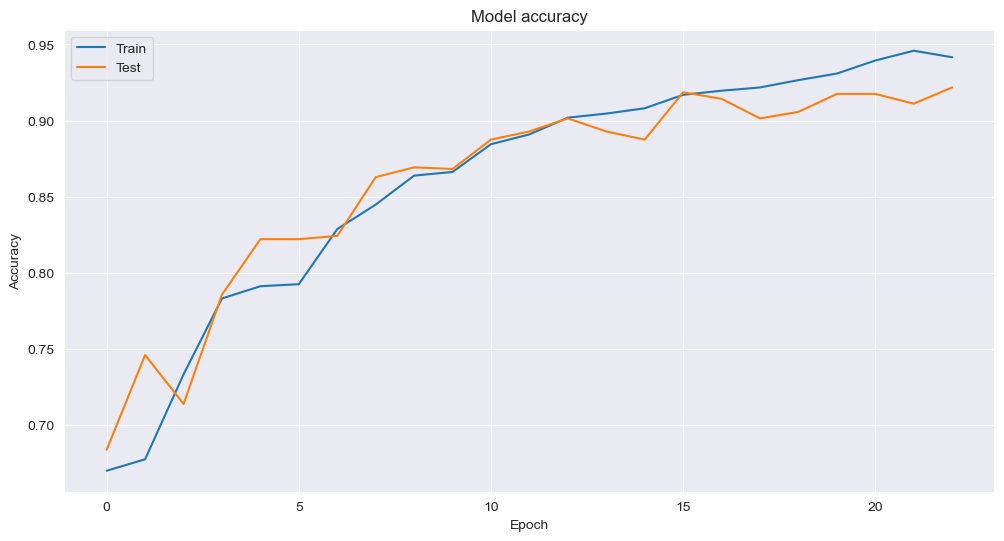

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


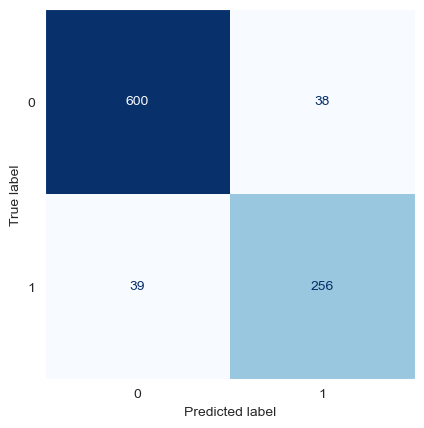

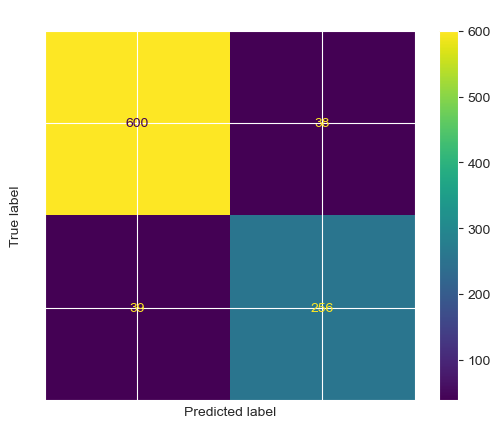

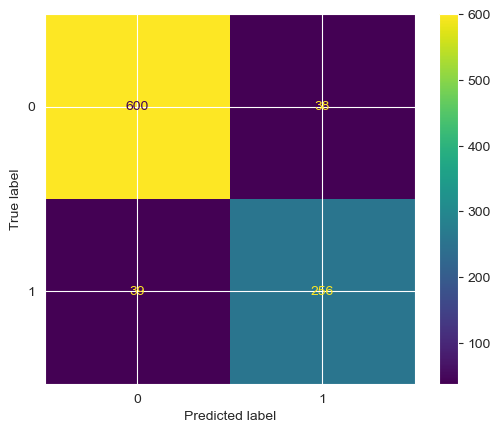

In [10]:
# Predict probabilities on test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary labels using threshold of 0.5
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=False)
plt.grid(False)
disp.plot(cmap='viridis')  # Use a different color map
plt.gca().xaxis.tick_top()
plt.gca().tick_params(colors='k')  # Set tick labels to black
# Change label color to white
plt.gca().tick_params(colors='white')

